<h1><center>Weak Gravitational Lensing</center></h1>

In this problem sheet, we will be calculating the ellipticity for a collection of lensed and unlensed galaxies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define plotting fonts
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=14)

<h2>1) Lensing Capability</h2>

The dark matter halos in which the visible matter of the Milky Way and other
galaxies are embedded are by most researchers believed to consist of weakly inter-
acting massive particles (WIMPS). A weakly-interacting massive particle (WIMP)
with a mass of $1000m_p$, where $m_p = 1.67 × 10^{−27}$ kg is the mass of the proton,
lenses the light of a star in the LMC, which is situated $50$ kpc from the Earth. 

<b>a</b>. Calculate the Einstein angular radius of the WIMP if it lies at a distance
$20$ kpc from the Earth.

<b>b</b>. How does this compare with the angular radius of the star if it has the same
radius, $6.96 × 10^8 m$, as the Sun? Will the microlensing effect of the WIMP be
noticeable (recall that lensing conserves the surface brightness of an object)? Are
dark matter microlensing surveys sensitive to the lensing of stars by WIMPs?

<b>c</b>. What is the Einstein radius of a brown dwarf with a mass of $0.05$ $M_{\odot}$ at the
same location as the WIMP? Will the lensing effect of the brown dwarf on the
background star be noticeable if there is a suitable alignment?

<i>Hints: 
- Assume all masses lens as point masses.
- You may also find chapter 3 of <a href="https://www.ita.uni-heidelberg.de/~jmerten/misc/meneghetti_lensing.pdf">Introduction to Gravitational Lensing</a> useful.
</i>

<h2>2) Measuring Ellipticity</h2>

<b>a</b>. Load the galaxy image

Tasks:
- Load the first image provided called "galaxies1.npy"
- Plot the image as done below

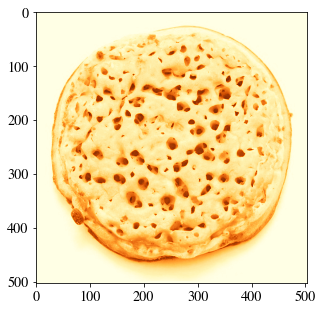

In [2]:
from skimage.io import imread

img = imread('images/example.png') 

# Combine RBG channels for simplicity
img_array = img.sum(axis = 2)

plt.figure(figsize = (5,5))
imgplot = plt.imshow(img_array, cmap = 'YlOrBr_r')
plt.show()

<b>b</b>. Find connected regions:

To be able to find galaxies automatically we have to create a <i>binary image</i> the image using a <i>heaviside filter</i>. 
\begin{equation}
    \Theta(x) = 
    \begin{cases}
    1, \text{for }x > x_{thresh} \\
    0, \text{else}.
    \end{cases}
\end{equation}
Where $x_{thresh}$ is some threshold value. This just means converting every pixel to either 1 or 0 depending on wether it's initial value is above or below some value.

Once we have our binary image we can then use a connected region function (such as `scipy.ndimage.label` defined <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html">here</a>) to label each of the isolated regions which are above the required threshold.

Note that while in this example we choose our connected regions to be based on <i>dark regions</i> for galaxies we will want the connected regions to be based on <i>light regions</i>.

- Convert the image into a binary image with some threshold value.
- Play around with different values until you find something that seems appropriate. This should be large enough to allow most of the different galaxies to be distinguished but not so large as to lose many of the smaller/fainter galaxies.

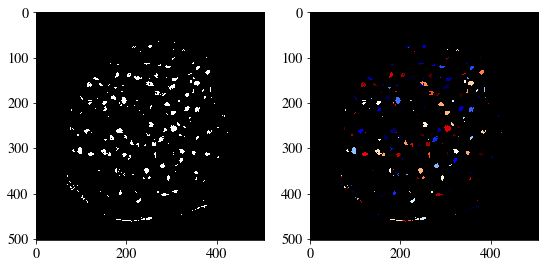

In [3]:
from scipy.ndimage import label

binaryImage = np.zeros(img_array.shape)
binaryImage[img_array<150] = 1

labeled_image, num_features = label(binaryImage)

plt.figure(figsize = (9,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(binaryImage, cmap = 'binary_r',interpolation='none')
# See different labels
ax2.imshow(labeled_image, cmap = 'flag_r',interpolation='none')

Now all of the pixels of each connected patch are labeled with a single integer $i$. This enables us to look at each object in isolation using the <i>mask</i>: `mask = [labeled_image == i]`

<b>c</b>. Removing small objects

We also don't want to condsider objects that are too small so we have to impose that the regions we consider contain more than some minimum number of pixels. An example of how to do this is shown below.

Tasks:

- Choose a sensible size threshold for the image of the galaxies
- Remove all objects smaller than this threshold

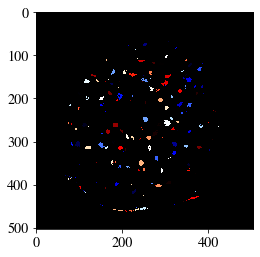

In [4]:
# Create a new labelled image with all values initially equal to zero
NoSmallObjects = np.zeros(img_array.shape)
# Set the size threshold to a sensible value
sizeThreshold = 1

# Create new object label
object_count = 1

# Loop over all objects
for i in range(1, num_features):
    # Create binary 2d array for pixels for this object
    mask = labeled_image==i
    # Calculate size of the object
    objectSize = len(labeled_image[mask])
    
    # If object bigger than threshold, add it to the new matrix
    if objectSize > sizeThreshold:
        # Mark pixels with new label
        NoSmallObjects[mask] = object_count
        # Increment label counter
        object_count += 1
        
# Plot new labelled image
plt.imshow(NoSmallObjects, cmap = 'flag_r', interpolation='none')

<b>d</b> Locating objects

We want to know where each pixel of our objects is in relation to the center of the image (where the lens is). We therefore need to create arrays of coordinates $x$ and $y$ which have the length equal to the size length of our image and which are zero in the center:
```
x = np.linspace(-length/2, length/2, length)
y = np.linspace(-length/2, length/2, length)
```

Tasks:
- For each object above this threshold, figure out the mid-point 
- Plot this midpoint ontop of the original image to check that they have been calculated correctly.

*Hints*: 
- *Use np.meshgrid() to create 2d arrays of the x and y coordinates.*
- *Ignore issues relating to objects at the edge of the image.*

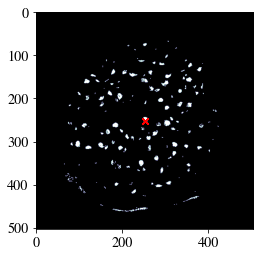

In [8]:
num_features2 = int(NoSmallObjects.max())

image_length = len(img_array[0,:])
x = np.arange(-int(image_length/2), int(image_length/2))
y = x

# Create 2d array for x and y
X, Y = np.meshgrid(x, y)

# Plot binary version of NoSmallObjects
plt.imshow(NoSmallObjects>0, cmap = "bone")

# Start from 1 since 0 is the background region
for i in range(1,num_features2):
    
    # Combine this mask with X and Y to calculate the average x and y position of each object
    mask = NoSmallObjects == i
    
    xcenter = 0
    ycenter = 0
    
    # Plot to check location
    plt.plot(xcenter+image_length/2, ycenter+image_length/2, 'rx')

<b>e</b>. Calculate $Q_{ij}$

In Section 4.2 of the textbook, we show that the second moment of the surface brightness $Q_{ij}$ is given by

\begin{equation}
    Q_{ij} = \frac{\int \text{d}^2 \theta \text{ }\Theta(\theta)(\theta_i - \bar{\theta}_i)(\theta_j - \bar{\theta}_j)}{\int \text{d}^2 \theta \text{ } \Theta(\theta)}.
\end{equation}

Where we have used the heaviside function as our weight function as this is the simplest to implement. 

The complex ellipticity is then given by

\begin{equation}
    \chi = \frac{Q_{11} - Q_{22} + 2iQ_{12}}{Q_{11} + Q_{22}}.
\end{equation}

Tasks:
- Extend the code above to calculate $Q_{ij}$ for each of the galaxies.
- Hence calculate the complex ellipcitity of each object
- Finally, calculate the magnitude of the complex ellipticity and plot this as a function of the distance of the object from the center of the image.
- Is there a trend? Would you expect this and why?


*Hint: Use $x = \theta_1$ and $y = \theta_2$*

<b>f</b>. Repeat the process

Tasks:
- Repeat the above steps for image "galaxies2.npy"
- How does the relationship between the magnitude of the complex ellipcitity with the distance from the center of the image compare to Galaxies1? Are there any obvious signs of lensing?

In [6]:
image_length = len(img_array[0,:])
x = np.arange(-int(image_length/2), int(image_length/2))
y = x

X, Y = np.meshgrid(x, y)

radius = np.empty(num_features2)
chi = np.empty(num_features2, dtype = complex)

# Start from 1 since 0 is the background region
for i in range(1,num_features2):
    
    # Combine this mask with X and Y to calculate the average x and y position of each object
    mask = NoSmallObjects == i
    
    # Calculate object midpoint
    xcenter = 0
    ycenter = 0
    
    # Calculate distance from center
    radius[i-1] = 0
    
    # Calculate second moment of the surface brightness
    Q11 = 0
    Q22 = 0
    Q12 = Q21 = 0
    
    # Calculate complex ellipticity
    chi[i-1] = 0

Text(0.5, 0, 'Radius (pixels)')

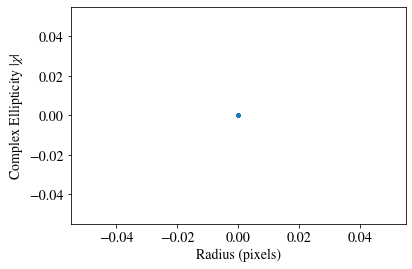

In [7]:
plt.plot(radius, abs(chi), ".")
plt.ylabel("Complex Ellipticity $|\chi|$")
plt.xlabel("Radius (pixels)")